In [2]:
#https://medium.com/analytics-vidhya/how-to-directly-download-kaggle-dataset-to-google-drive-aa06175712e2
import os

os.environ['KAGGLE_USERNAME'] = "" # username from the json file 
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [3]:
!kaggle datasets download -d shadabhussain/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!ls

captions.npy		     flickr_data       next_words.npy
flickr_8k_test_dataset.txt   Flickr_Data       sample_data
flickr_8k_train_dataset.txt  image_names.npy   train_encoded_images.p
flickr_8k_val_dataset.txt    images.npy
flickr8k.zip		     model_weights.h5


In [5]:
!unzip -e flickr8k.zip 

Archive:  flickr8k.zip
replace Flickr_Data/Flickr_Data/Flickr_TextData/CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
#from image_processing import processing

In [7]:
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation,BatchNormalization, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.preprocessing import image, sequence

In [52]:
# Load data
images_dir = os.listdir("./flickr_data/Flickr_Data/")
images_path = './flickr_data/Flickr_Data/Images/'
captions_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = './flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [9]:
(len(captions)-1)

40460

In [10]:
k=captions[random.randrange(0,40460)].split('#')
print(k)
k[1][2:]

['3258396041_69717247f7.jpg', "1\tA man holding a microphone in front of a person 's face ."]


"A man holding a microphone in front of a person 's face ."

In [11]:
#Loading key-value pairs as image-caption 

caption = {}

for i in range(len(captions)-1):
    #print(captions[i].split("#"))
    try:
        photo, cap  = captions[i].split("#")
        cap_ = '<start> '+ cap[2:] + ' <end>'
    except:
        pass
    if photo in caption:
        caption[photo].append(cap_)
    else:
        caption[photo] = [cap_]


['2869491449_1041485a6b.jpg', '2\ttwo dogs play together .']


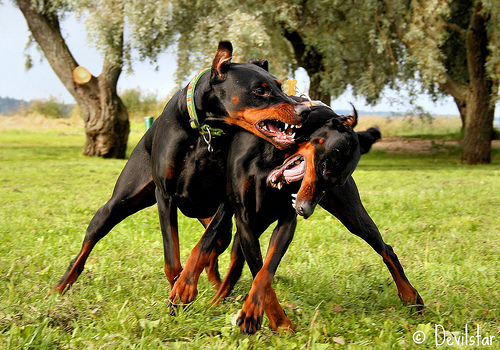

<start> Two Dobermans fighting or playing together on a lawn . <end>
<start> Two dogs fight on the grass . <end>
<start> two dogs play together . <end>
<start> Two dogs wrestle in the grass . <end>
<start> Two large dogs are fighting with teeth bared near some trees . <end>


In [12]:
#Displaying a random Image along with its captions
k=captions[random.randrange(0,40460)].split('#')
print(k)
from IPython.display import Image , display
z=Image(filename=images_path+k[0])
display(z)
for i  in caption[k[0]] :
    print(i)

In [13]:
print(len(caption))
len(x_train)

8092


6001

In [14]:
capt = list(caption.keys())


In [15]:
def gen_dataset(dataset,caption,train):
  for img in train:
        if img == '':
            continue
        for capt in caption[img]:
            dataset.write((img+"\t"+capt+"\n").encode())
            dataset.flush()
  dataset.close()

In [16]:
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [17]:
gen_dataset(train_dataset,caption,x_train)
gen_dataset(test_dataset,caption,x_test)
gen_dataset(val_dataset,caption,x_val)

In [18]:
train_dataset = open('flickr_8k_train_dataset.txt','rb')
print(len(train_dataset.readlines()))

30000


In [19]:
res_model=ResNet50(include_top=False,weights='imagenet',pooling='avg',input_shape=(224,224,3))

In [20]:
import numpy as np
from PIL import Image as pilimage
from keras.applications.vgg16 import VGG16
from keras.models import  Model
def processing(image_name,model = None,get_histogram = False,size = None,convert_BGR = True,image_path = images_path, mean_of_data = [104,117,124], return_arr = False):
       
        
    '''
    Subtracting the dataset mean serves to "center" the data. Additionally, you ideally would like to divide by the stddev of that
    feature or pixel as well if you want to normalize each feature value to a z-score. 
    
    PARAMETER:
    image_name --> name of the image
    model --> if you want to extract features then give the model
    get_histogram --> Boolean for displaying histogram
    size --> tuple in the form of (width,height)
    convert_BGR--> convert to BGR Boolean type
    mean)of_data --> to normalize the data in order of the channel
    
    RETURN:
    pred_value if model given.A column array.
    im_arr image array
    '''
    if model == None:
        
        base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
        model = Model(base_model.input, base_model.layers[-2].output)
        
    path = image_path + str(image_name)
    with pilimage.open(path) as image:
        if not(size == None):
            image = image.resize(size)
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape((image.size[1], image.size[0], 3))
        im_arr = np.expand_dims(im_arr, axis=0)
    
    
    
    if get_histogram == True:
        print(image.histogram())

    if convert_BGR == True:
        im_arr = im_arr[ :,:, :, ::-1]
    if not(mean_of_data == None):
        im_arr[ :,:, :, 0] -= mean_of_data[0]
        im_arr[ :,:, :, 1] -= mean_of_data[1]
        im_arr[ :,: ,:, 2] -= mean_of_data[2]
        
    if not(model == None):    
        pred = model.predict(im_arr)
        pred = np.reshape(pred, pred.shape[1])
        if return_arr == False:
            return pred
        if return_arr == True:
            return pred, im_arr
    
    return im_arr

In [21]:
train_data = {}

temp=0
for i in x_train:
    try:
        images_path=images_path
        #print(images_path)
        path = images_path + i
        #print(path)
        train_data[i]  = processing(i,size = (224,224),convert_BGR=False,model = res_model
                        ,mean_of_data=[0,0,0],return_arr=False,image_path= images_path) # local module
    except:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [22]:
train_data = {}

temp=0
for i in tqdm(x_train):
    try:
        
        path = images_path + i
        #print(path)
        train_data[i]  = processing(i,size = (224,224),convert_BGR=False,model = res_model
                        ,mean_of_data=[0,0,0],return_arr=False,image_path= images_path) # local module
    except:
        pass

100%|██████████| 6001/6001 [05:01<00:00, 19.92it/s]


In [24]:
with open( "./train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [25]:
ds = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t').values

print(ds.shape)

(29999, 2)


In [26]:
ds[0:5]

array([['2513260012_03d33305cf.jpg',
        '<start> A black dog is running after a white dog in the snow . <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Black dog chasing brown dog through snow <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Two dogs chase each other across the snowy ground . <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Two dogs play together in the snow . <end>'],
       ['2513260012_03d33305cf.jpg',
        '<start> Two dogs running through a low lying body of water . <end>']],
      dtype=object)

In [27]:
all_caption=[]
for i in range(ds.shape[0]):
    all_caption.append(ds[i, 1])
    
print(len(all_caption))

29999


In [28]:
words = [i.split() for i in all_caption]

In [29]:
vocabulary = []
for i in words:
    vocabulary.extend(i)
vocabulary = list(set(vocabulary))

print(len(vocabulary))

vocab_size = len(vocabulary) +1
vocab_size

8253


8254

In [73]:
word_in = {val:index+1 for index, val in enumerate(vocabulary)}
in_word = {str(index+1):val for index, val in enumerate(vocabulary)}

In [31]:
max_len = 40
padded_sequences, subsequent_words = [], []
for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_in[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(29999,)
(29999,)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [32]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])
for ix in tqdm(range(4000,4000+num_of_images)):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])
np.save("./captions.npy", captions)
np.save("./next_words.npy", next_words)
print(captions.shape)
print(next_words.shape)

100%|██████████| 2000/2000 [07:29<00:00,  4.45it/s]


(25697, 40)
(25697, 8254)


In [33]:
image_names = []

for ix in tqdm(range(4000,6000)):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
image_names = np.asarray(image_names)

np.save("./image_names.npy", image_names)

print(len(image_names))

100%|██████████| 2000/2000 [00:00<00:00, 252433.21it/s]

25697


In [34]:
!ls train_encoded_images.p

train_encoded_images.p


In [35]:
with open('./train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f)
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(29999, 2048)


In [36]:
images = []

for ix in tqdm(range(4000,6000)):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

100%|██████████| 2000/2000 [00:00<00:00, 159185.68it/s]


(25697, 2048)


In [41]:
embedding_size = 128
max_len = 40



image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(BatchNormalization())
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,784
Trainable params: 262,528
Non-trainable params: 256
_________________________________________________________________


In [42]:
language_model = Sequential()

language_model.add(Embedding(input_dim=8254, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(275, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 275)           444400    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           35328     
Total params: 1,536,240
Trainable params: 1,536,240
Non-trainable params: 0
_________________________________________________________________


In [43]:

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(150, return_sequences=True)(conca)
x = LSTM(550, return_sequences=False)(x)
x = Dense(8254)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

#model.load_weights("./model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
______________________________________________________________________________________________

In [40]:
captions.shape

(25697, 40)

In [44]:
captions=np.array(captions)


hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

Epoch 1/200
51/51 [==============================] - 10s 130ms/step - loss: 7.1145 - accuracy: 0.0626
Epoch 2/200
51/51 [==============================] - 7s 130ms/step - loss: 5.4085 - accuracy: 0.0767
Epoch 3/200
51/51 [==============================] - 7s 131ms/step - loss: 5.3504 - accuracy: 0.0776
Epoch 4/200
51/51 [==============================] - 7s 131ms/step - loss: 5.3365 - accuracy: 0.0759
Epoch 5/200
51/51 [==============================] - 7s 132ms/step - loss: 5.3080 - accuracy: 0.0787
Epoch 6/200
51/51 [==============================] - 7s 134ms/step - loss: 5.2719 - accuracy: 0.0764
Epoch 7/200
51/51 [==============================] - 7s 134ms/step - loss: 5.1978 - accuracy: 0.0796
Epoch 8/200
51/51 [==============================] - 7s 135ms/step - loss: 5.1677 - accuracy: 0.0819
Epoch 9/200
51/51 [==============================] - 7s 135ms/step - loss: 5.1366 - accuracy: 0.0811
Epoch 10/200
51/51 [==============================] - 7s 138ms/step - loss: 5.1154 - accur

In [45]:
model.save('model_weights1.h5')

In [75]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_in[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = in_word[str(np.argmax(preds[0]))]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [49]:
photo = os.listdir(images_path)

In [80]:
from PIL import Image as pilimage
from IPython.display import Image as ipython_img  
def get_caption(input_image):
    
    
  
    filename=images_path+input_image
    z_ = ipython_img(filename)
    display(z_)  
    pred_test = processing(input_image,size = (224,224),convert_BGR=False,model = res_model
                          ,mean_of_data=[0,0,0],return_arr=False,image_path=images_path) # local module
    Argmax_Search = predict_captions(pred_test)
    print(Argmax_Search)
    print('\n')

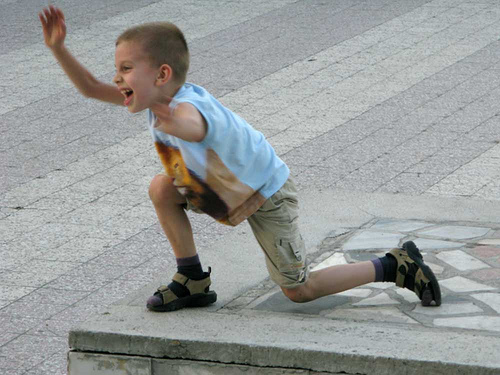

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


A boy in a red balancing skateboard at the side .




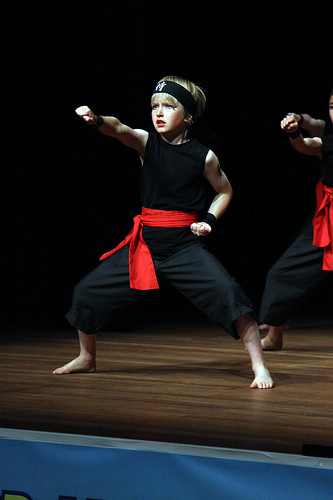

A boy in a red dress is beard and a woody .




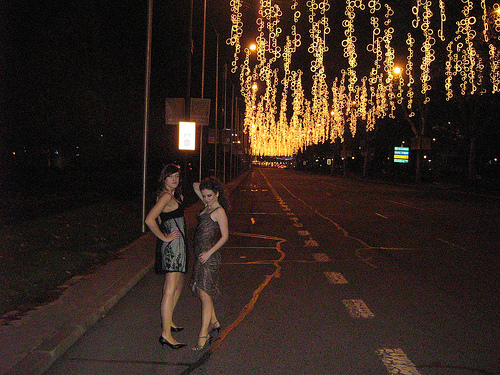

A couple sits on a of a people of blue people is white inside




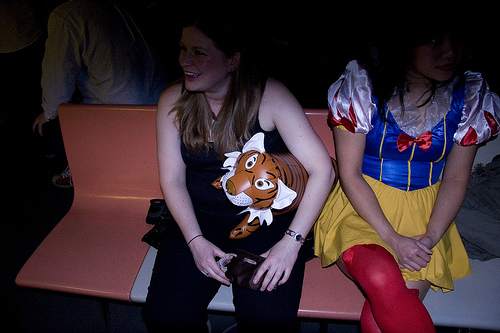

A little girl wearing a blue striped shirt and playing her on the her band .




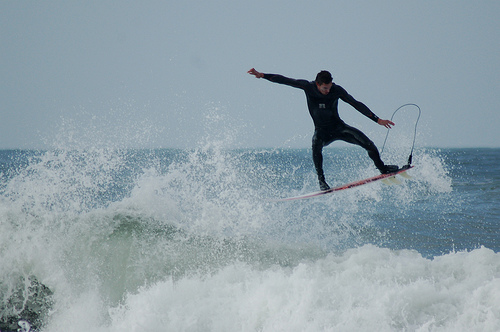

A boy is jumping through a lake




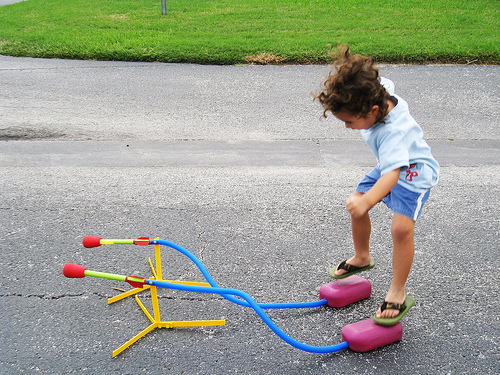

A girl is about in a mud .




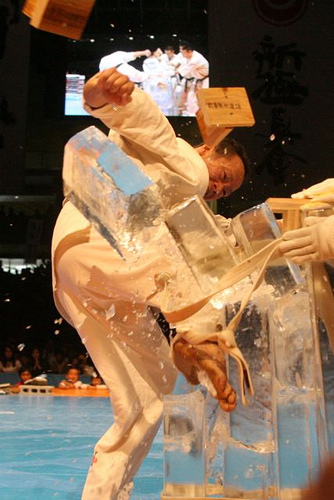

A basketball children are wrestling on inflatable a raft .




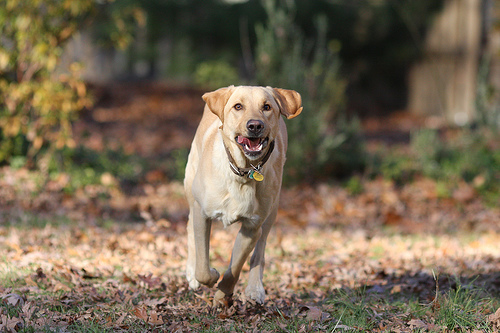

A dog runs across a tongue hanging hanging in grass in a grass .




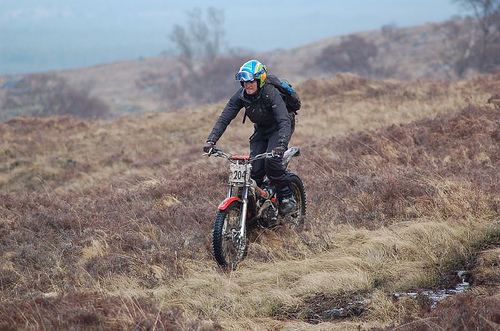

A boy is fights air in water .




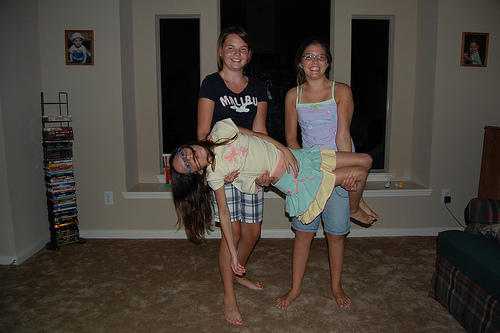

A child in a white shirt stands in a store with a hallway or his monster .




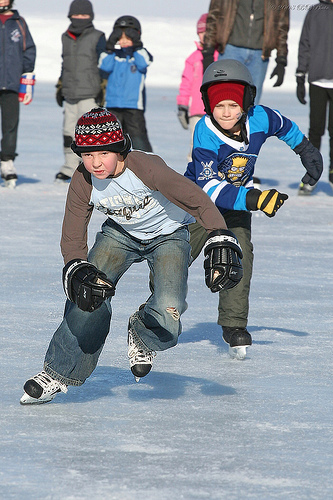

A sports playing on the water with a on the ground paddles .




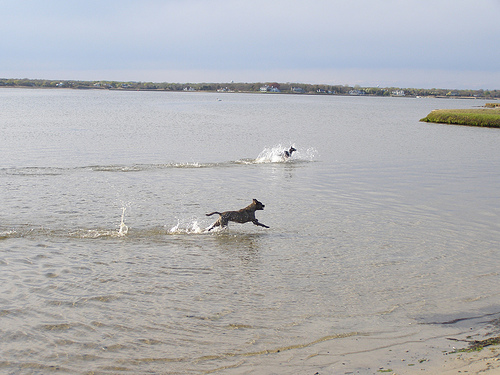

A boy is tutu and skiing on shore .




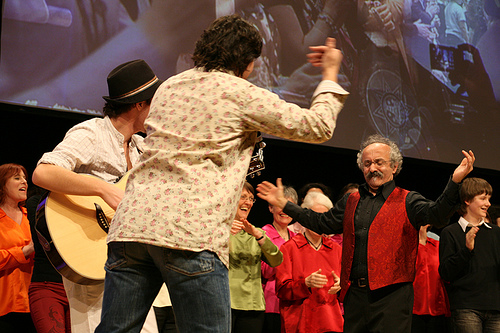

Three boys in pictures with a clothing with pictures watching camera .




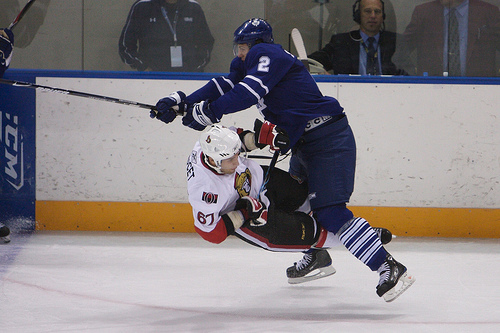

A little boy with a holding a ball in a field .




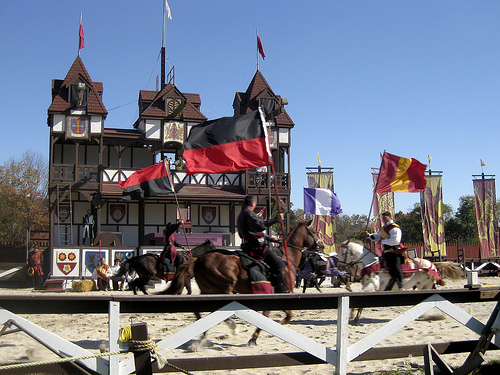

A woman in a vehicle on a rock




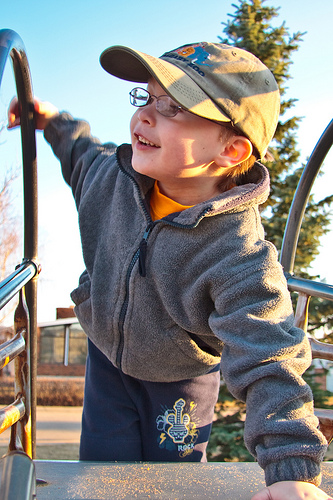

A girl is blue shirt and black t-shirt takes the building .




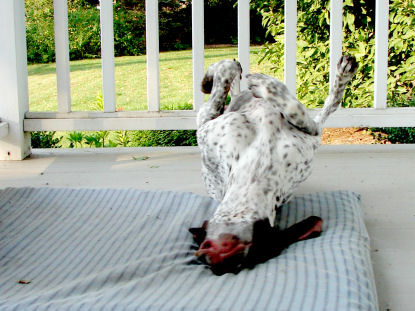

A girl on a stunt show fence with a fallen sprinkler .




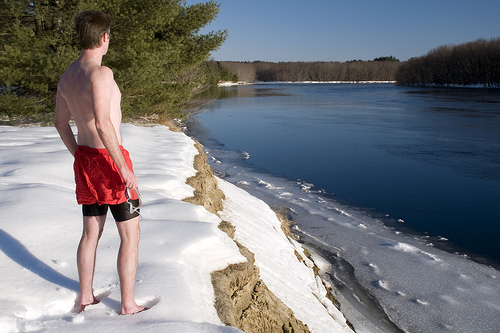

A boy in a red shirt and jumping on a lake and from the to water .




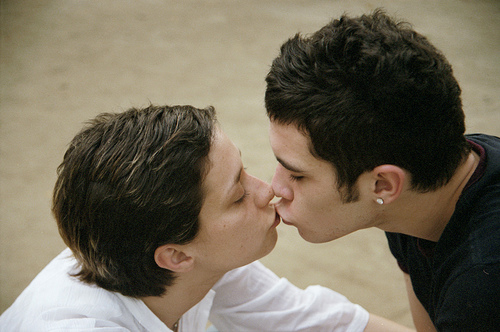

A man in a blue shirt is shirt stands away away away to blue and blue while looks while blue for his also for his other while his while his for his to his people for his people back




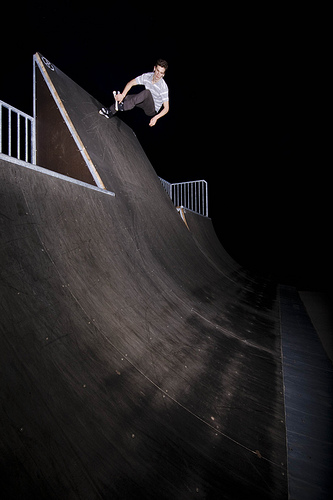

A skateboarder is is skateboarding above the legs above the top of a his park course .




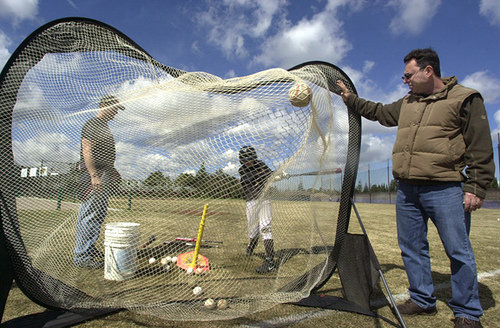

A man sits on a public of a his past air .




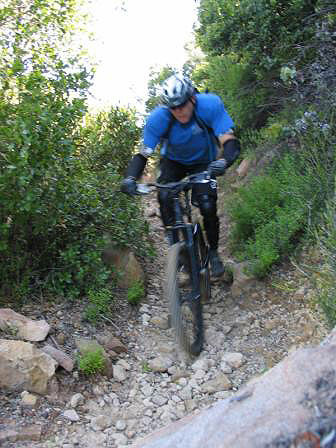

A man rides his dirt bike down a rocky trail .




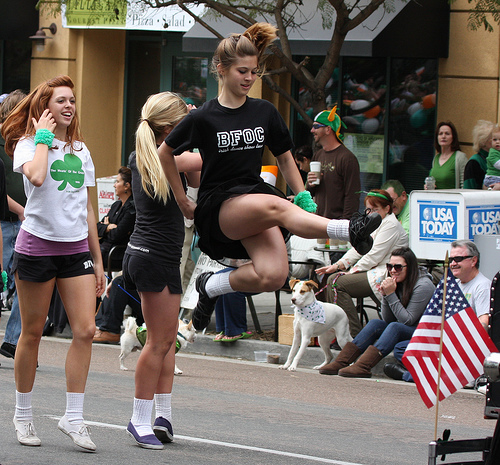

A family in a posing behind a behind two holding two holding two crowd .




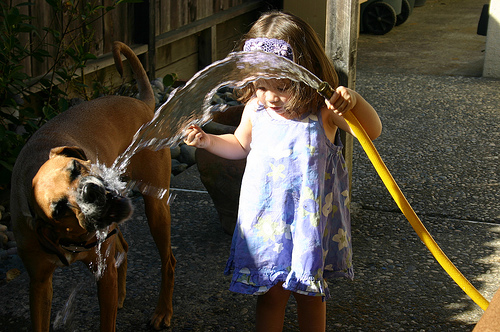

Two dogs are getting a sit to a people behind front




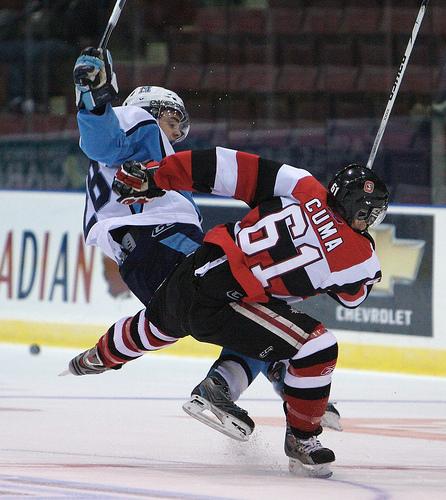

A player player is strip and red guarding the goal .




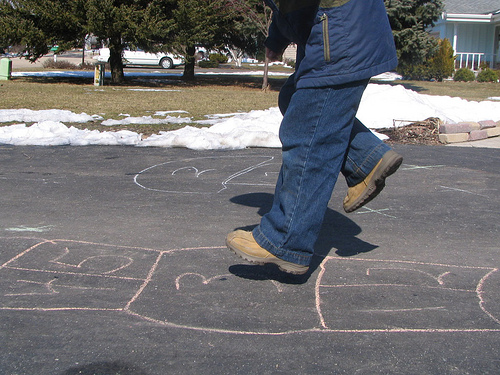

A boy in a pink shirt is performing blue head and hanging hanging hanging and is is wearing sunglasses climbing swing .




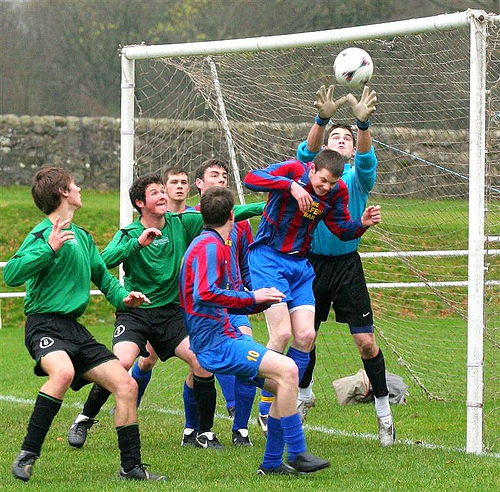

A soccer kids are soccer in a ball .




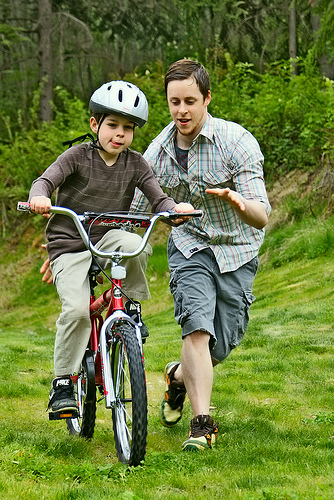

A boy in a blue shirt is is shirt is riding a horse .




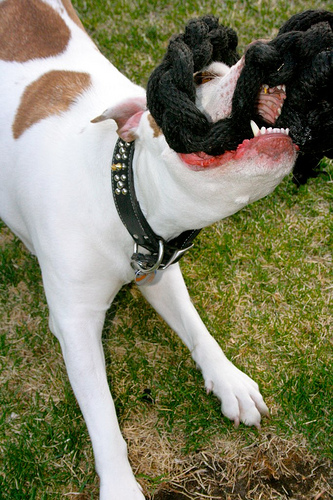

A brown dog is running on grass while blue blue to blue along it .




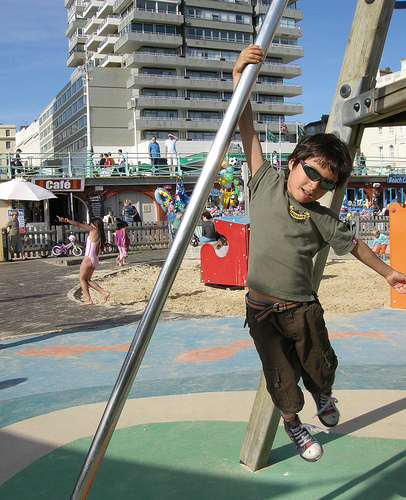

A man is pull an vehicle to an pickup multicolored boardwalk .




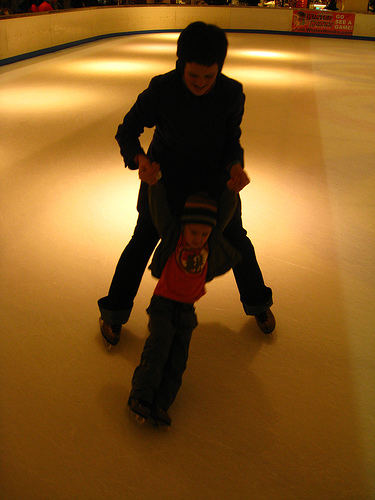

A man wearing red uniform standing and red jersey playing a to a leg leg soccer to a leg dark leg leg soccer to players kick game .




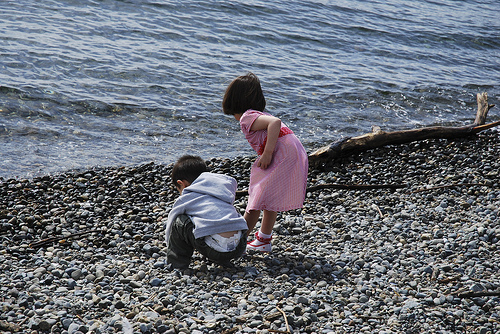

A boy in a orange performs up puddles




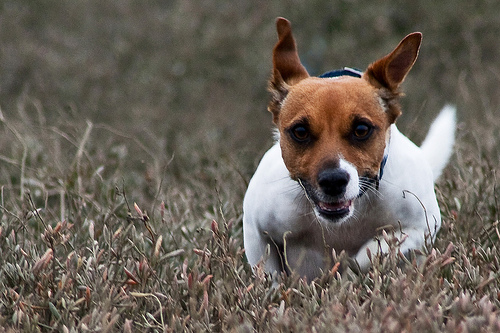

A brown and white dog running in a grass .




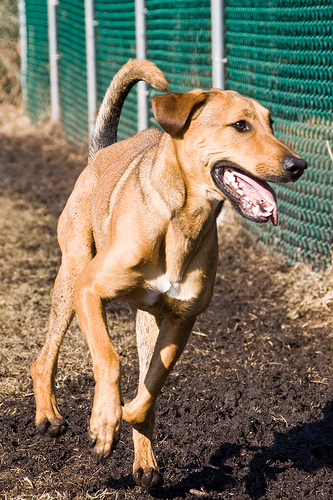

A brown dog is running through the sand with two running in sand .




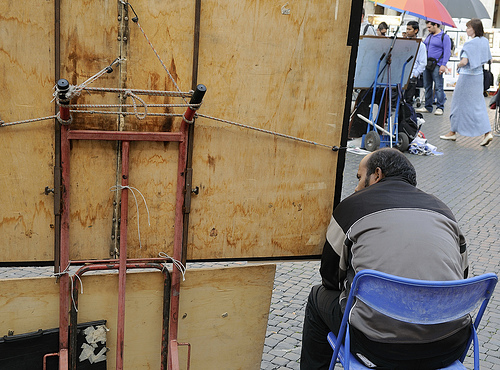

A boy playing scooter on cabin .




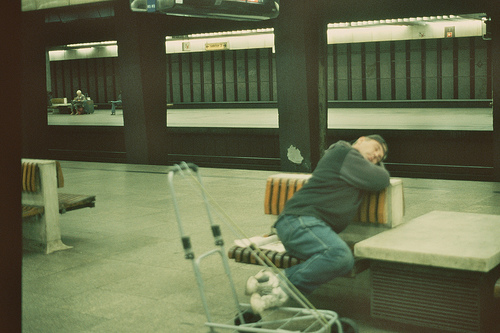

A man in a blue hoodie stands in a sidewalk .




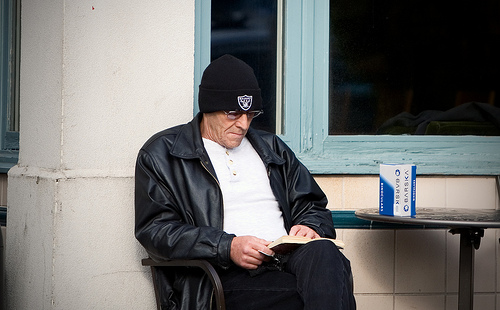

A man and a woman stare in front .




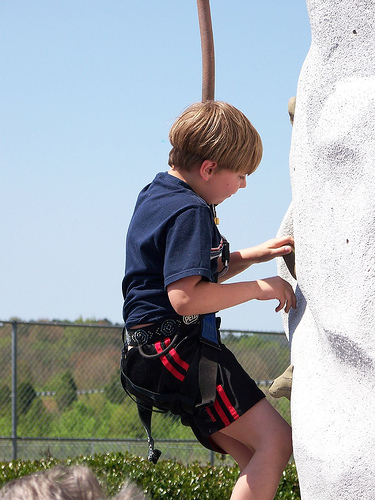

A small child is running on the grass in the grass .




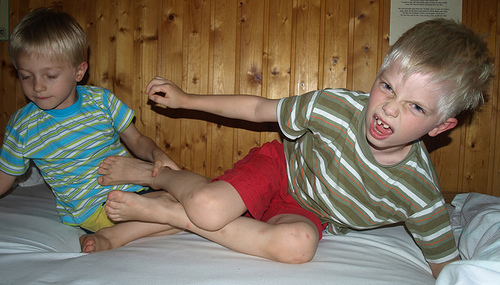

A young girl is sitting and white and black t-shirt and white and white by white wearing a white looking in front .




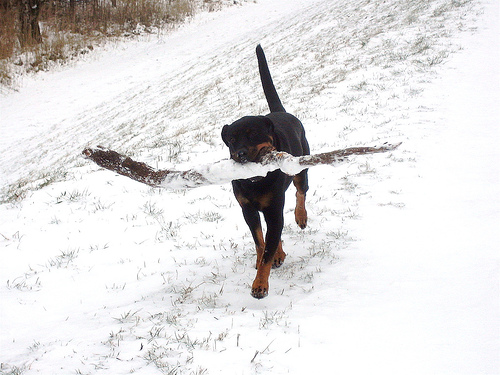

A man jumps over the water .




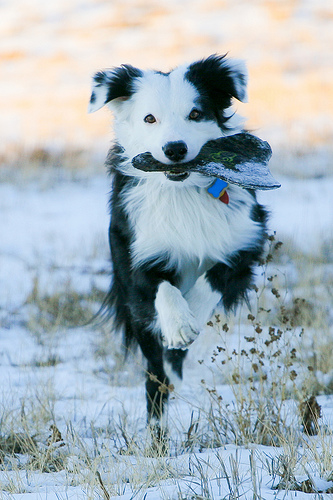

A black and white dog running with something in his mouth .




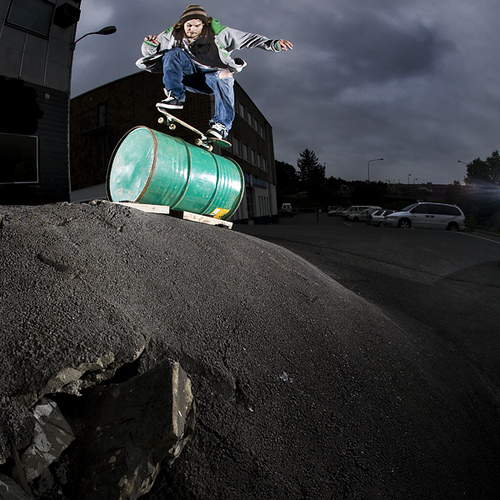

A man wearing a white shirt jumps ramp at the park .




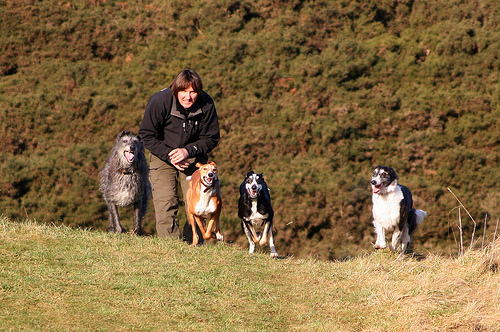

A woman and a and white and a and a dog and and dog jumps dog in a fence .




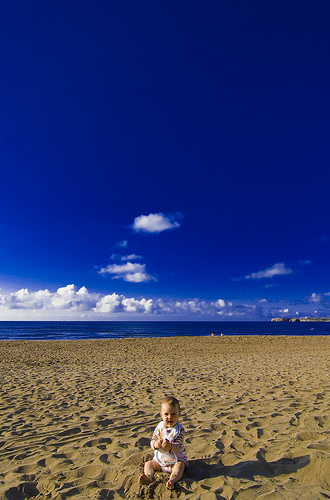

A child is walking on a water by a beach .




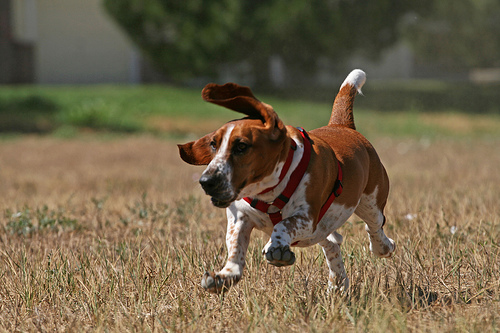

A brown and white dog runs on the field with patches patches in the grass .




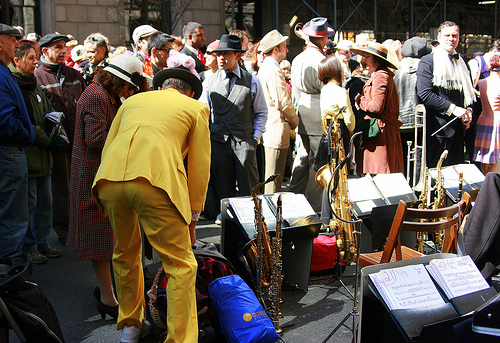

A old people walking in front of a European people




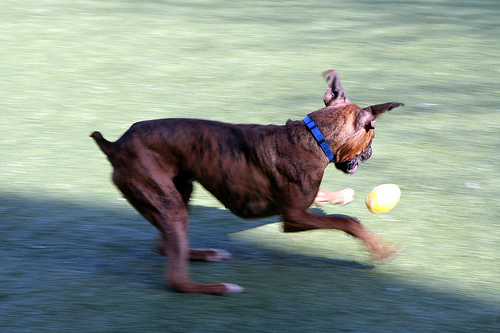

A brown dog is playing ball in a yard .




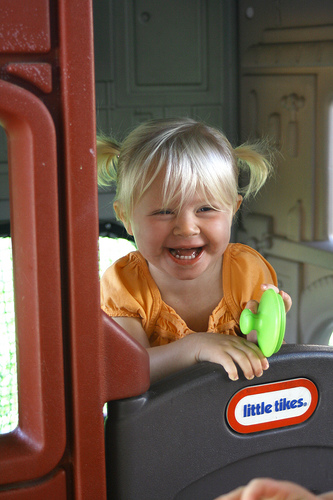

A boy in a blue shirt and blue shirt is holding a mittens down lot .




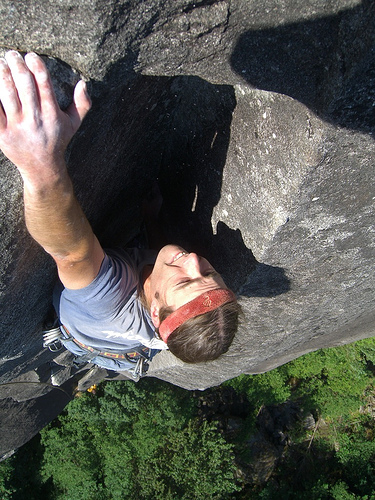

Man climbing a sheet rock face .




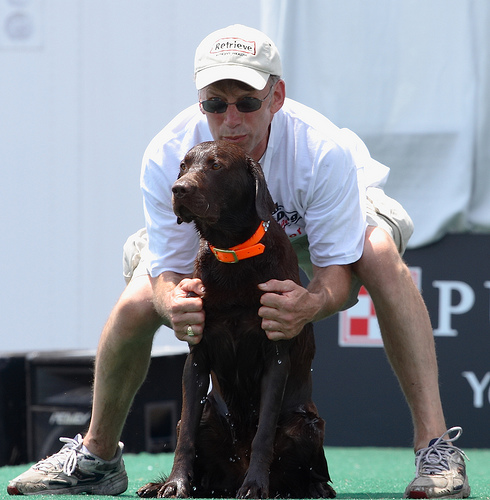

A small blond girl is shirt with a white dress shirt on a store .




In [82]:
for i in range(50):
    try:
        p=random.randrange(0,len(photo)+1)
        get_caption(photo[p])
    except:
            pass